Reference: https://colab.research.google.com/drive/1yjBGec3BOXg44R9HkuLxipI3spVKjomR?usp=sharing#scrollTo=LJtnWc3b89qn

 !pip install bitsandbytes accelerate nltk lightning peft datasets Pillow

In [2]:
from transformers import BitsAndBytesConfig, LlavaNextForConditionalGeneration, AutoProcessor
from datasets import load_dataset
import torch
import json
from huggingface_hub import notebook_login
notebook_login()

In [3]:
if torch.cuda.is_available():
    print("PyTorch is connected to GPU.")
    print(f"GPU Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
else:
    print("PyTorch is not connected to GPU.")

PyTorch is connected to GPU.
GPU Device Name: NVIDIA A100 80GB PCIe
Number of GPUs available: 1
Current GPU: 0


In [4]:
MAX_LENGTH = 256
MODEL_ID = "llava-hf/llava-v1.6-mistral-7b-hf"
REPO_ID = "Farzad-R/llava-v1.6-mistral-7b-cordv2"
# WANDB_PROJECT = "LLaVaNeXT"
# WANDB_NAME = "llava-next-demo-cord"

In [5]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

In [6]:
USE_LORA = False
USE_QLORA = True

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [16]:
from torch.utils.data import Dataset
from typing import Any, Dict
import random

class LlavaDataset(Dataset):
    """
    PyTorch Dataset for LLaVa. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and ground truth data (json/jsonl/txt).
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        split: str = "train",
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset = self.dataset.take(100)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

    def json2token(self, obj: Any, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            return obj

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.

        Returns:
            image : the original Receipt image
            target_sequence : tokenized ground truth sequence
        """
        sample = self.dataset[idx]

        # inputs
        image = sample["image"]
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1

        return image, target_sequence

In [17]:
train_dataset = LlavaDataset("naver-clova-ix/cord-v2",  split="train", sort_json_key=False)
val_dataset = LlavaDataset("naver-clova-ix/cord-v2", split="validation", sort_json_key=False)

In [20]:
counter = 0
for idx in range(len(train_dataset)):
    image, target_sequence = train_dataset[idx]
    print(f"[INST] <image>\nExtract JSON [\INST] {target_sequence}")
    counter +=1
    if counter == 10:
        break

[INST] <image>
Extract JSON [\INST] <s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,

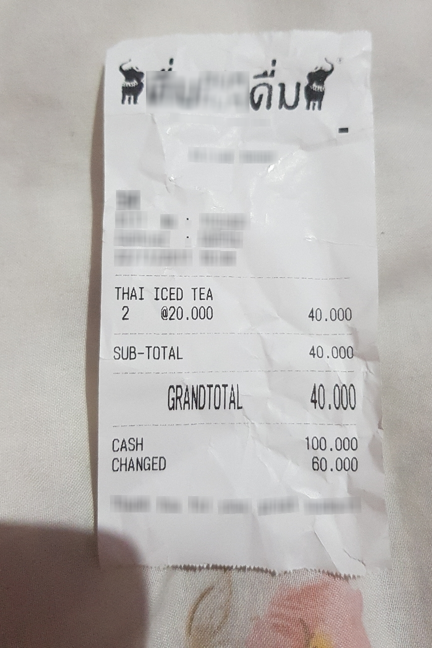

In [21]:
width, height = image.size
image = image.resize((int(0.5*width), int(0.5*height)))
image

In [22]:
def train_collate_fn(examples):
    images = []
    texts = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        prompt = f"[INST] <image>\nExtract JSON [\INST] {ground_truth}"
        texts.append(prompt)

    batch = processor(text=texts, images=images, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    image_sizes = batch["image_sizes"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values, image_sizes, labels


def eval_collate_fn(examples):
    # we only feed the prompt to the model
    images = []
    texts = []
    answers = []
    for example in examples:
        image, ground_truth = example
        images.append(image)
        # TODO: in the future we can replace this by processor.apply_chat_template
        prompt = f"[INST] <image>\nExtract JSON [\INST]"
        texts.append(prompt)
        answers.append(ground_truth)

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values = batch["pixel_values"]
    image_sizes = batch["image_sizes"]

    return input_ids, attention_mask, pixel_values, image_sizes, answers

In [23]:
import lightning as L
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class LlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values, image_sizes, labels = batch

        outputs = self.model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            pixel_values=pixel_values,
                            image_sizes=image_sizes,
                            labels=labels
                          )
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, image_sizes, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, image_sizes=image_sizes, max_new_tokens=MAX_LENGTH)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [33]:
config = {"max_epochs": 1,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 1,
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
          "num_workers": 4
}

model_module = LlavaModelPLModule(config, processor, model)

In [34]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from huggingface_hub import HfApi

api = HfApi()

class PushToHubCallback(Callback):
    # def on_train_epoch_end(self, trainer, pl_module):
    #     print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
    #     pl_module.model.push_to_hub(REPO_ID,
    #                                 commit_message=f"Training in progress, epoch {trainer.current_epoch}")
    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

In [35]:
%%time
# from lightning.pytorch.loggers import WandbLogger

# wandb_logger = WandbLogger(project=WANDB_PROJECT, name=WANDB_NAME)

trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
        # logger=wandb_logger,
        callbacks=[
            PushToHubCallback(),
            early_stop_callback],
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 3.9 B  | train
--------------------------------------------
22.2 M    Trainable params
3.9 B     Non-trainable params
3.9 B     Total params
15,751.029Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prediction: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>

<s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.23059866962305986


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prediction: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_unitprice>23.000</s_unitprice><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>

<s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_unitprice>23.000</s_unitprice><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
 Normed ED: 0.5485232067510548


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prediction: <s_menu><s_nm>S-Ovaltine</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price><s_sub><s_nm>50%</s_nm><sep/><s_nm>1,918</s_nm><s_price>18,181</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>20,000</s_subtotal_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>

</s_menu><s_sub_total><s_subtotal_price>20,000</s_subtotal_price></s_sub_total><s
    Answer: <s_menu><s_nm>S-Ovaltine 50%</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price><s_vatyn>10% Tax Included</s_vatyn></s_menu><s_sub_total><s_subtotal_price>18,181</s_subtotal_price><s_tax_price>1,818</s_tax_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.379746835443038


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prediction: <s_menu><s_nm>1X-M-CarameL Black Tea</s_nm><s_unitprice>28,000</s_unitprice><s_cnt>1X</s_cnt><s_price>28,000</s_price><s_sub><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>28,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>28,000</s_total_price><s_menuqty_cnt>1X</s_menuqty_cnt></s_total>

<s_menu><s_nm>1X-M-CarameL Black Tea</s_nm><s_unitprice>28,000</s_unitprice><s_cnt>1X</s_cnt><s_price>28,000</s_price><s
    Answer: <s_menu><s_nm>M-Caramel Black Tea</s_nm><s_unitprice>@28,000</s_unitprice><s_cnt>1X</s_cnt><s_price>28,000</s_price><s_sub><s_nm>70%</s_nm><sep/><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>28,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>28,000</s_total_price><s_cashprice>28,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.3156779661016949
Prediction: <s_menu><s_nm>BBQ Chicken - Sedang</s_nm><s_unitprice>41,

`Trainer.fit` stopped: `max_epochs=1` reached.


Pushing model to the hub after training


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/88.7M [00:00<?, ?B/s]

CPU times: user 2min 8s, sys: 54.5 s, total: 3min 2s
Wall time: 3min 7s
